In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import pytorch_lightning as pl


class MultiEntityVariationalAutoEncoder(pl.LightningModule):
    def __init__(self, num_entities, beta=0.1, latent_dim=12):
        super(MultiEntityVariationalAutoEncoder, self).__init__()

        self.num_entities = num_entities
        self.beta = beta
        self.latent_dim = latent_dim

        actual_latent_dim = latent_dim * 2 

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, actual_latent_dim, 3, padding=1),
        )

        self.decoder_1 = nn.Sequential(
            nn.Conv2d(self.latent_dim + 1, 32, 1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 32, 1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 32, 1, padding=0),
        )

        self.decoder_2 = nn.Sequential(
            nn.Conv2d(32, 32, 1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 32, 1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 1, 1, padding=0),
        )

        
            


    def forward(self, x):
        batch_size = x.shape[0]

        y = self.encoder(x)

        mu = y[:, :self.latent_dim, :, :]
        logvar = y[:, self.latent_dim:, :, :]

        

        x_range = torch.arange(0, x.shape[3], device=x.device, dtype=torch.float32)
        y_range = torch.arange(0, x.shape[2], device=x.device, dtype=torch.float32)
        x_grid, y_grid = torch.meshgrid(x_range, y_range)

        std = torch.exp(0.5 * logvar)

        parametrization = torch.randn_like(std) * std + mu

        delta_xy_pred = parametrization[:, :2].view(batch_size, 2, -1)
        parametrization = parametrization[:, 2:].view(batch_size, self.latent_dim - 2, -1)
        

        # Calculate the KL divergence from the prior of gaussian distribution with mean 0 and std 1
        # to the posterior of the gaussian distribution with mean mu and std std
        # KL divergence is calculated as 0.5 * sum(1 + log(std^2) - mu^2 - std^2)

        kl_divergence = -0.5 * torch.sum(1 + logvar - mu**2 - std**2, dim=1)
        kl_divergence = kl_divergence.view(batch_size, -1)
        # find the i,j indices of the max value num_entities elements in the kl_divergence tensor
        # these indices will be used to select the num_entities most important entities

        top_kl_divergence, indices = torch.topk(kl_divergence, self.num_entities, dim=1)
        indices = indices.detach()
        intermediate_feature_map = None

        latents = torch.stack(
            [
                torch.stack(
                    [parametrization[batch_idx, :, idx] for idx in indices[batch_idx]]
                ) for batch_idx in range(batch_size)
            ]
        )
        
        # repeat latents to match the size of input image
        # (batch_size, num_entities, latent_dim, 1, 1) -> (batch_size, num_entities, latent_dim, x.shape[2], x.shape[3]
        latents = latents[:, :, :, None, None].repeat(1, 1, 1, x.shape[2], x.shape[3])

        # grid channel is a tensor of size (batch_size, latent_dim, 2, x.shape[2], x.shape[3])
        # it contains the x and y coordinates of each pixel in the image
        grid_channel = torch.stack([x_grid, y_grid])[None, None]
        grid_channel = grid_channel.repeat(batch_size, self.num_entities, 1, 1, 1)

        # center the grid channel around the coordinates of the entities
        x_coord = indices // y.shape[3]
        y_coord = indices % y.shape[3]
        
        # add 0.5 to the coordinates to center the grid channel around the coordinates of the entities
        # scale the coordinates to match the size of the input image
        x_coord = (x_coord + 0.5) * x.shape[2] / y.shape[2]
        y_coord = (y_coord + 0.5) * x.shape[3] / y.shape[3]

        xy_coord = torch.stack([x_coord, y_coord], dim=2)[..., None, None]
        grid_channel = grid_channel - xy_coord

        # add the predicted delta_xy to the grid channel
        pred_delta_xy = torch.stack(
            [
                torch.stack(
                    [delta_xy_pred[batch_idx, :, idx] for idx in indices[batch_idx]]
                ) for batch_idx in range(batch_size)
            ]
        )[..., None, None]
        grid_channel = grid_channel + pred_delta_xy * 2

        r_channel = torch.sqrt(torch.sum(grid_channel**2, dim=2, keepdim=True))

        
        # concatenate the grid channel and the latents
        # (batch_size, num_entities, latent_dim + 2, x.shape[2], x.shape[3])
        intermediate_feature_map = torch.cat([latents, r_channel / 4, grid_channel / 4], dim=2)

        # flatten batch and num_entities dimensions
        # (batch_size * num_entities, latent_dim + 2, x.shape[2], x.shape[3])
        intermediate_feature_map = intermediate_feature_map.view(
            batch_size * self.num_entities, -1, x.shape[2], x.shape[3]
        )

        decoded_feature_map = self.decoder_1(intermediate_feature_map)

        # unflatten batch and num_entities dimensions
        # (batch_size, num_entities, 32, x.shape[2], x.shape[3])
        decoded_feature_map = decoded_feature_map.view(
            batch_size, self.num_entities, -1, x.shape[2], x.shape[3]
        )
        
        # reduce entity dimension by taking max
        combined_entities = torch.max(decoded_feature_map, dim=1)[0]

        y = self.decoder_2(combined_entities)

        return [y, indices, kl_divergence, delta_xy_pred, mu, logvar]

    def loss_function(self, x, x_hat, kl_divergence, mu, logvar):
        # Reconstruction loss
        reconstruction_loss = F.mse_loss(x_hat, x)
        # KL divergence loss
        kl_divergence_loss = torch.mean(torch.sum(kl_divergence, dim=1), dim=0)

        # MN weighting
        weight_MN = x.shape[1] * x.shape[2] * x.shape[3] / 12

        # Total loss
        loss = reconstruction_loss + kl_divergence_loss * weight_MN * self.beta

        return {
            "loss": loss,
            "reconstruction_loss": reconstruction_loss,
            "KLD": kl_divergence_loss,
            "weighted_KLD": kl_divergence_loss * weight_MN * self.beta,
        }


class MEVAE(pl.LightningModule):
    def __init__(self, num_entities, beta=0.1):
        super().__init__()
        self.model = MultiEntityVariationalAutoEncoder(num_entities, beta)

    def forward(self, x):
        return self.model(x)

    def training_step(self, x, batch_idx):
        x_hat, indices, kl_divergence, xy, mu, logvar = self(x)
        kl_divergence = [kld[idx] for kld, idx in zip(kl_divergence, indices)]

        kl_divergence = torch.stack(kl_divergence)
        loss_dict = self.model.loss_function(x, x_hat, kl_divergence, mu, logvar)
        self.log_dict(loss_dict, on_epoch=True, prog_bar=True)
        return loss_dict["loss"]

    def validation_step(self, x, batch_idx):
        x_hat, indices, kl_divergence, xy, mu, logvar = self(x)
        kl_divergence = [kld[idx] for kld, idx in zip(kl_divergence, indices)]

        kl_divergence = torch.stack(kl_divergence)

        loss_dict = self.model.loss_function(x, x_hat, kl_divergence, mu, logvar)
        # self.log_dict(loss_dict, on_step=True, on_epoch=True, prog_bar=True)
        return loss_dict["loss"]

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=2e-4)

0
100
200
300
400
500
600
700
800
900


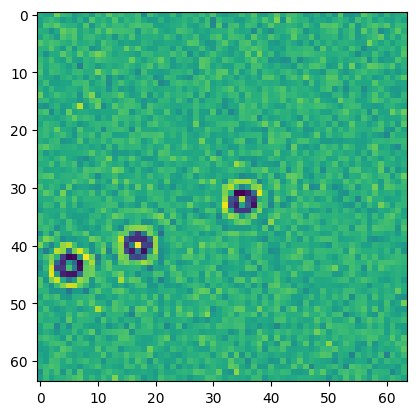

In [97]:
import deeptrack as dt
import numpy as np

image_size = 64

particle = dt.MieSphere(
    refractive_index=1.55,
    radius=1e-6,
    z=lambda: np.random.uniform(-2, 2) * dt.units.um,
    position=lambda: np.random.uniform(5, image_size - 5, 2),
)

optics = dt.Brightfield(
    NA=0.4,
    magnification=5,
    resolution=3e-6,
    wavelength=0.6e-6,
    output_region=(0, 0, image_size, image_size),
)

# %%
particles = particle ^ (lambda: np.random.randint(2, 6)) 
image_pipeline = optics(particles) >> dt.Gaussian(sigma=0.1)

image_pipeline.update().plot()
# %%

# generate a dataset of 1000 images
images = []
for i in range(1000):
    if i % 100 == 0:
        print(i)
    images.append(image_pipeline.update()()._value)

In [100]:
# convert to tensor
tensors = torch.tensor(np.array([i for i in images])).float() - 1
# make channel first
tensors = tensors.permute(0, 3, 1, 2)
train, test = torch.utils.data.random_split(tensors, [900, 100])

# create dataloaders
train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=32, shuffle=False)

In [111]:
import matplotlib.pyplot as plt

def plot(model, test_loader):
    # forwards pass
    x = next(iter(test_loader))
    x = x[1:2]
    x = x.to(model.device)
    x_hat, indices, kl_divergence, xy, mu, logvar = model(x)

    flatind = indices[0, :].detach().cpu().numpy()
    xy = xy[0, :, indices].detach().cpu().numpy()
    row, col = np.unravel_index(flatind, (16, 16))
    row = (row + .5) * 4 - xy[0, :] * 2
    col = (col + .5) * 4 - xy[1, :] * 2
    kdiv = kl_divergence.view(1, 16, 16).detach().cpu().numpy()[0]
    

    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(x[0, 0, :, :].detach().cpu().numpy(), cmap="gray")
    plt.colorbar()
    plt.imshow(kdiv, extent=[0, 64, 64, 0], alpha=0.5, cmap="Blues")
    plt.scatter(col, row, c="blue", s=10)

    plt.subplot(1, 2, 2)
    plt.imshow(
        x_hat[0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, :, :].min(),
        vmax=x[0, 0, :, :].max(),
        cmap="gray",
    )
    plt.colorbar()
    return plt

def plot(model, test_loader):
    # forwards pass
    x = next(iter(test_loader))
    x = x[1:2]
    x = x.to(model.device)
    x_hat, indices, kl_divergence, xy, mu, logvar = model(x)

    x = x.detach().cpu().numpy()

    xy_mu = mu[0, :2].view(2, -1).detach().cpu().numpy()
    xy_logvar = logvar[0, :2].view(2, -1).detach().cpu().numpy()

    flatind = indices[0, :].detach().cpu().numpy()

    xy = xy_mu[:, flatind]
    xy_std = np.exp(xy_logvar[:, flatind] / 2)
    print(xy.shape)
    
    pos_gauss_map = np.zeros_like(x[0, 0])

    row, col = np.unravel_index(flatind, (16, 16))
    xp = (row + .5) * 4 - xy[0, :] * 2
    yp = (col + .5) * 4 - xy[1, :] * 2

    

    def gaussian_2d(x, y, x_std, y_std, x_size, y_size):
        xr = np.arange(x_size)
        yr = np.arange(y_size)
        X, Y = np.meshgrid(xr, yr)
        
        g =  np.exp(-((X - x) ** 2 / (2 * x_std ** 2) + (Y - y) ** 2 / (2 * y_std ** 2)))
        g *= 1 / (2 * np.pi * x_std * y_std)
        return g

    for i in range(xy.shape[1]):

        pos_gauss_map += gaussian_2d(
            yp[i], xp[i], xy_std[1, i] * 2, xy_std[0, i] * 2, 64, 64
        )

    kdiv = kl_divergence.view(1, 16, 16).detach().cpu().numpy()[0]
    # print(pos_gauss_map)

    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(x[0, 0, :, :], cmap="gray")
    plt.colorbar()
    plt.imshow(kdiv, alpha=0.5, cmap="Blues", extent=[0, 64, 64, 0])
    alpha = np.sqrt(1 / np.square(xy_std).sum(0))
    alpha /= alpha.max()
    plt.scatter(yp, xp, c="blue", s=30, alpha=alpha)

    plt.subplot(1, 2, 2)
    plt.imshow(
        x_hat[0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, :, :].min(),
        vmax=x[0, 0, :, :].max(),
        cmap="gray",
    )
    plt.colorbar()
    return plt

In [105]:
model = MEVAE(num_entities=10, beta=0)

(2, 10)


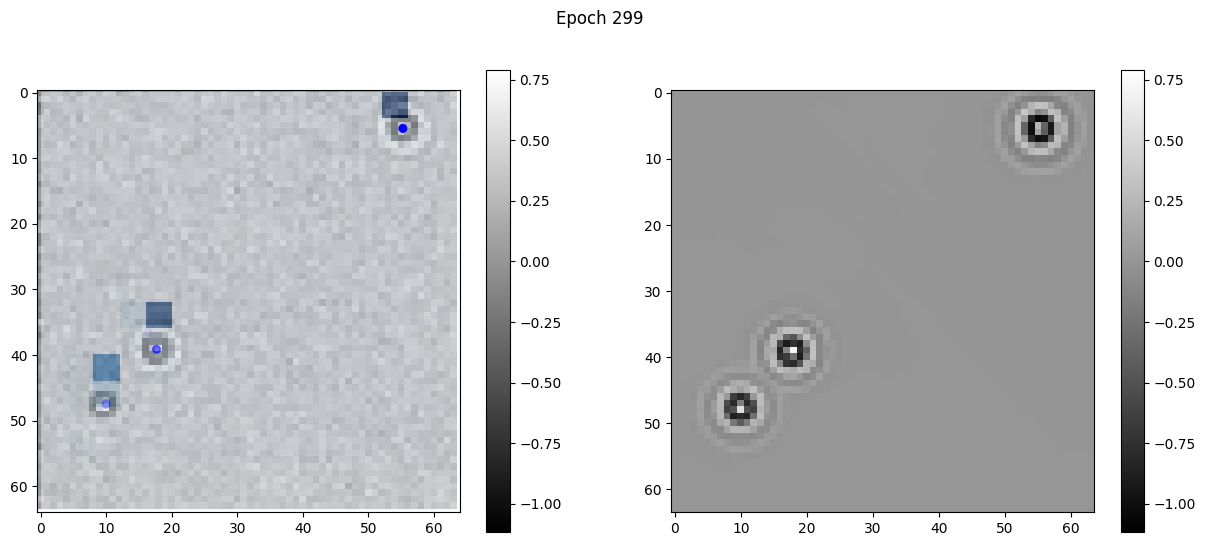

`Trainer.fit` stopped: `max_epochs=300` reached.


(2, 10)


<module 'matplotlib.pyplot' from 'c:\\Users\\GU\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

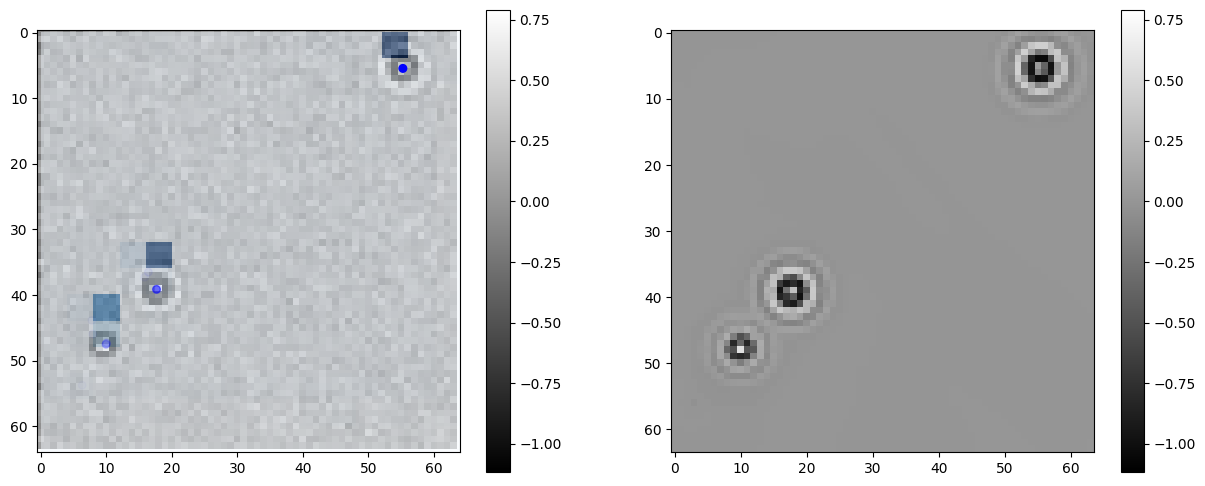

In [112]:
# anneal beta from 1e-10 to 1e-8 over 150 epochs
import numpy as np
import IPython.display as ipd
def beta_annealing(epoch):
    # if epoch >= 150:
    #     return 1e-8
    # else:
    logs = np.logspace(-8.3, -7, 300)
    return logs[int(epoch)]
    return 1e-8

class BetaCallback(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        pl_module.model.beta = beta_annealing(trainer.current_epoch)

class PlotCallback(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        ipd.clear_output(wait=True)
        plot(pl_module, test_loader)
        plt.suptitle(f"Epoch {trainer.current_epoch}")
        plt.show()
        

trainer = pl.Trainer(gpus=1, max_epochs=300, callbacks=[BetaCallback(), PlotCallback()])
trainer.fit(model, train_loader)
plot(model, test_loader)